# Comparing Embeddings Models

Explore different embedding models available in the Sentence Transformers ecosystem and understand their trade-offs

Embedding models differ in many ways, including :
1. Size and computational requirements
2. Language support (monolingual vs. multilingual)
3. Context length limitations
4. Embedding dimensionality 
5. Performance on specific tasks


Sentence Transformers provides access to a wide range of pre-trained models optimized for different use cases. Some popular models include : 

- `all-MiniLM-L6-v2` : A compact, efficient model that produces 384-dimensional embeddings
- `all-mpnet-base-v2` : A more powerful model with 768-dimensional embeddings
- `paraphrase-multilingual-MiniLM-L12-v2` : Supports 50+ languages
- `multi-qa-mpnet-base-dot-v1` : Optimized for question-answering tasks


When selecting an embedding model for an application, factors to consider :

1. **Accuracy requirements** : More powerful models typically produce better embeddings but require more computation
2. **Inference speed** : Smaller models are faster but may sacrifice some accuracy
3. **Resource constraints** : Model size affects memory usage and deployment options
4. **Multilingual needs** : Some models support multiple languages, while others are optimized for English
5. **Specific tasks** : Models fine-tuned for particular tasks often perform better on those tasks

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 11})
import random
import time

from sentence_transformers import SentenceTransformer, util

In [5]:
# Different embeddings models
models = [
    "all-MiniLM-L6-v2",  # Small model (384d)
    "all-MiniLM-L12-v2",  # Medium model (384d)
    "all-mpnet-base-v2",  # Large model (768d)
    "paraphrase-multilingual-MiniLM-L12-v2"  # Multilingual model (384d)
]

In [ ]:
# Example sentences semantically similar
sentences = [
    # Technology
    ["Machine learning models require significant computational resources.",
     "AI systems need a lot of computing power to train."],

    # Programming
    ["What's the best algorithm for text classification?'",
     "How can I optimize my neural network training time?"],

    # Weather
    ["The weather forecast predicts rain tomorrow.",
     "It's going to be wet outside tomorrow according to meteorologists."],

    # Office
    ["I need to get a new computer for my office.",
     "My workplace needs updated computing equipment."],

    # Health
    ["Regular exercise improves cardiovascular health.",
     "Working out frequently is good for your heart."],

    # Food
    ["The restaurant serves authentic Italian pasta dishes.",
     "You can get genuine Italian noodle recipes at that dining place."]
]

In [6]:
# Generate dissimilar pairs by mixing topics
dissimilar_pairs = []

for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            dissimilar_pairs.append([sentences[i][0], sentences[j][0]])

# Select 6 dissimilar pairs to match similar pairs count
random.seed(42)  # For reproducibility
random_pairs = random.sample(dissimilar_pairs, 6)

# Create flat list of all sentences for encoding
all_sentences = []
for pair in sentences + random_pairs:
    all_sentences.extend(pair)

# remove duplicate
all_sentences = list(set(all_sentences))

In [7]:
# function to evaluate embeddings models
def evaluate_model(model_name, all_sentences, sentences, random_pairs):
    start_time = time.time()
    
    # Load model
    model_load_time = time.time()
    model = SentenceTransformer(model_name)
    model_load_time = model_load_time - time.time()
    
    # Encode sentences 
    encoding_time = time.time()
    embeddings_dict = {
        sentence: model.encode(sentence) for sentence in all_sentences
    }
    encoding_time = encoding_time - time.time()
    
    # Embeddings dimension
    dim = next(iter(embeddings_dict.values())).shape[0]
    
    # Get model size (parameters)
    model_size_mb = sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024
    
    # Calculate similarities for similar pairs
    similar_scores = []
    for s1,s2 in sentences:
        score = util.cos_sim(
            embeddings_dict[s1].reshape(1, -1),
            embeddings_dict[s2].reshape(1, -1)
        ).item()
        similar_scores.append(score)
        
    # Calculate similarities for dissimilar pairs
    dissimilar_scores = []
    for s1,s2 in random_pairs:
        score = util.cos_sim(
            embeddings_dict[s1].reshape(1, -1),
            embeddings_dict[s2].reshape(1, -1)
        ).item()
        dissimilar_scores.append(score)
    
    # Calculate average scores and contrast
    avg_similar = sum(similar_scores) / len(similar_scores)
    avg_dissimilar = sum(dissimilar_scores) / len(dissimilar_scores)
    contrast = avg_similar - avg_dissimilar
    
    total_time = time.time() - start_time
    
    # Return results
    return {
        "Model": model_name,
        "Dimensions": dim,
        "Size (MB)": model_size_mb,
        "Load Time (s)": model_load_time,
        "Encoding Time (s)": encoding_time,
        "Total Time (s)": total_time,
        "Avg Similar Score": avg_similar,
        "Avg Different Score": avg_dissimilar,
        "Contrast": contrast,
        "Similar Scores": similar_scores,
        "Dissimilar Scores": dissimilar_scores
    }

In [9]:
# Run the evaluation for all models
results = []
for model_name in models:
    print(f"Evaluating : {model_name} ...")
    current_result = evaluate_model(model_name, all_sentences, sentences, random_pairs)
    results.append(current_result)
    print(f"Completed evaluation of {model_name}")
    print()

Evaluating : all-MiniLM-L6-v2 ...
Completed evaluation of all-MiniLM-L6-v2

Evaluating : all-MiniLM-L12-v2 ...
Completed evaluation of all-MiniLM-L12-v2

Evaluating : all-mpnet-base-v2 ...
Completed evaluation of all-mpnet-base-v2

Evaluating : paraphrase-multilingual-MiniLM-L12-v2 ...
Completed evaluation of paraphrase-multilingual-MiniLM-L12-v2



In [10]:
# Convert to DataFrame for easier analysis
data = pd.DataFrame(results)

df =  data[["Model", "Dimensions", "Size (MB)", "Encoding Time (s)", "Avg Similar Score", "Avg Different Score", "Contrast"]]
df

,Model,Dimensions,Size (MB),Encoding Time (s),Avg Similar Score,Avg Different Score,Contrast
0,all-MiniLM-L6-v2,384,86.644043,-0.106136,0.573949,0.030175,0.543774
1,all-MiniLM-L12-v2,384,127.258301,-0.139819,0.610976,0.082879,0.528098
2,all-mpnet-base-v2,768,417.657715,-0.187581,0.661512,0.038167,0.623345
3,paraphrase-multilingual-MiniLM-L12-v2,384,448.813477,-0.140491,0.636167,0.085618,0.550549


In [12]:
# Display detailed pair analysis
print("=== Detailed Pair Analysis ===")
for idx, model_data in enumerate(results):
    print(f"Model: {model_data["Model"]}")
    print("Similar pairs:")
    
    for i, score in enumerate(model_data["Similar Scores"]):
        print(f"  - Pair {i+1}: {sentences[i][0]} | {sentences[i][1]} | Score: {score:.4f}")
    
    print("Dissimilar pairs:")
    for j, score in enumerate(model_data["Dissimilar Scores"]):
        print(f"  - Pair {j+1}: {random_pairs[j][0]} | {random_pairs[j][1]} | Score: {score:.4f}")
    print()

=== Detailed Pair Analysis ===
Model: all-MiniLM-L6-v2
Similar pairs:
  - Pair 1: Machine learning models require significant computational resources. | AI systems need a lot of computing power to train. | Score: 0.5377
  - Pair 2: What's the best algorithm for text classification?' | How can I optimize my neural network training time? | Score: 0.2310
  - Pair 3: The weather forecast predicts rain tomorrow. | It's going to be wet outside tomorrow according to meteorologists. | Score: 0.7471
  - Pair 4: I need to get a new computer for my office. | My workplace needs updated computing equipment. | Score: 0.5624
  - Pair 5: Regular exercise improves cardiovascular health. | Working out frequently is good for your heart. | Score: 0.6454
  - Pair 6: The restaurant serves authentic Italian pasta dishes. | You can get genuine Italian noodle recipes at that dining place. | Score: 0.7201
Dissimilar pairs:
  - Pair 1: Regular exercise improves cardiovascular health. | Machine learning models re

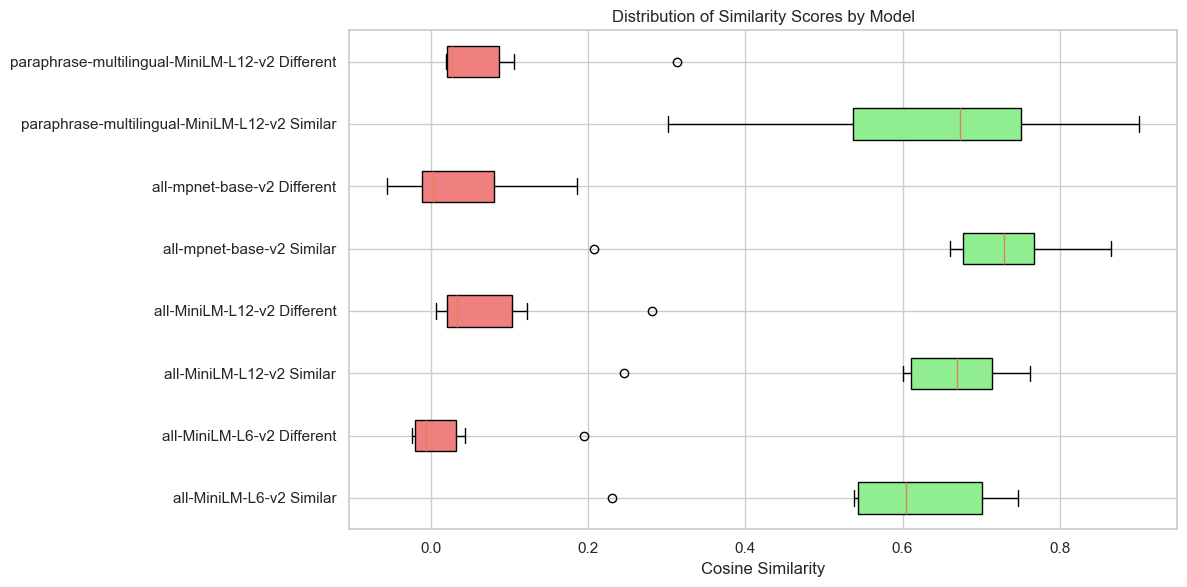

In [13]:
# Visualize the results - Boxplot comparison
plt.figure(figsize=(12, 6))

# Prepare data for boxplot
boxplot_data = []
model_names = []

for model_data in results:
    boxplot_data.append(model_data["Similar Scores"])
    boxplot_data.append(model_data["Dissimilar Scores"])
    model_names.append(f"{model_data["Model"]} Similar")
    model_names.append(f"{model_data["Model"]} Different")

# Create a color map for the boxes
colors = ["lightgreen", "lightcoral"] * len(models)

# Create boxplot
bp = plt.boxplot(boxplot_data, patch_artist=True, vert=False)
plt.yticks(range(1, len(model_names) + 1), model_names)
plt.xlabel("Cosine Similarity")
plt.title("Distribution of Similarity Scores by Model")

# Color the boxes
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    
plt.tight_layout()
plt.show()

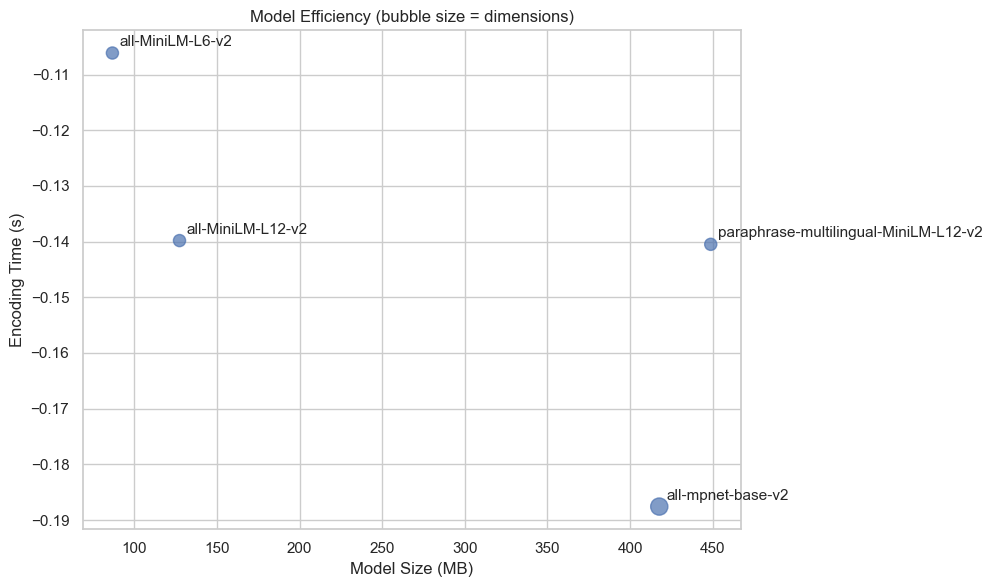

In [14]:
# Visualize the results - Efficiency metrics
plt.figure(figsize=(10, 6))

plt.scatter(df["Size (MB)"], df["Encoding Time (s)"], s=df["Dimensions"]/5, alpha=0.7)

for i, model in enumerate(df["Model"]):
    plt.annotate(model, (df["Size (MB)"].iloc[i], df["Encoding Time (s)"].iloc[i]), xytext=(5, 5), textcoords="offset points")

plt.xlabel("Model Size (MB)")
plt.ylabel("Encoding Time (s)")
plt.title("Model Efficiency (bubble size = dimensions)")
plt.grid(True)

plt.tight_layout()
plt.show()

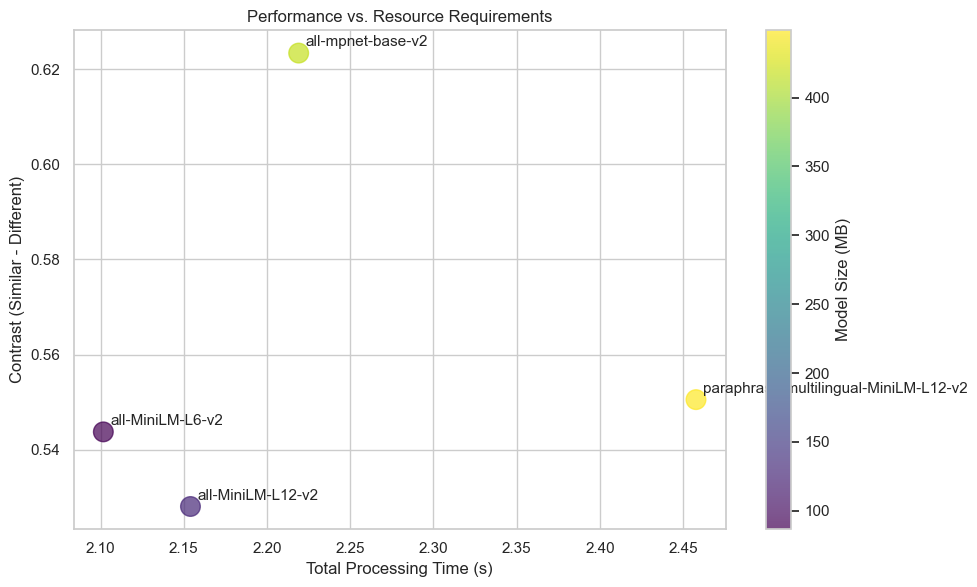

In [17]:
# Visualize the results - Performance vs Resources
plt.figure(figsize=(10, 6))

sc = plt.scatter(data["Total Time (s)"], df["Contrast"], c=df["Size (MB)"], s=200, cmap="viridis", alpha=0.7)
plt.colorbar(sc, label="Model Size (MB)")

for i, model in enumerate(df["Model"]):
    plt.annotate(model, (data["Total Time (s)"].iloc[i], df["Contrast"].iloc[i]), xytext=(5, 5), textcoords="offset points")
    
plt.xlabel("Total Processing Time (s)")
plt.ylabel("Contrast (Similar - Different)")
plt.title("Performance vs. Resource Requirements")
plt.grid(True)

plt.tight_layout()
plt.show()

# Takeaways

- The contrast score is often the most important metric. A model with higher contrast will be better at distinguishing relevant from irrelevant information.

- Consider the trade-offs : Larger models typically have better semantic understanding but require more resources and run slower. What's more important for the application; accuracy or speed ?
- Test with domain-specific data : While this comparison uses general examples, the best results are testing with examples from a specific domain.
- Think about constraints : If deploying on mobile or edge devices, model size matters more. For server applications, might prioritize accuracy.
- Consider multilingual needs : If the application needs to work across languages, a multilingual model might be essential even if it's not the top performer in English.